In [1]:
import config
import os, numpy as np, pandas, sklearn
import mido
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
## NN libs
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
import keras
from keras import regularizers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.optimizers import SGD, Adam
from keras.layers import Input, Dense, Activation, Conv1D, Conv2D, Dropout, Flatten
from keras.layers import Conv2DTranspose, Reshape, MaxPooling2D, UpSampling2D, UpSampling1D, MaxPooling1D
from keras.layers import LocallyConnected1D, LocallyConnected2D
from keras.layers import Input, LSTM, RepeatVector
from keras.models import Model
from keras.callbacks import TensorBoard

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# local libs
import config, models, functions
from data import data, midi, midi_generators as g
from utils import io, models_io

 Context :: namedtuple(
[ max_t = float
, dt = float
, n_instances = int
, note_length = int
, bpm = float
, tempo = float
, ticks_per_beat = int
]



In [4]:
context = data.init()

Setting up params

 >> Context(max_t=3.0, dt=0.1, n_instances=30, note_length=0.03, bpm=120.0, tempo=500000, ticks_per_beat=480)


In [5]:
# fn = (config.dataset_dir + '4-floor-120bpm.mid')
# mid = io.import_midifile(fn)

## Setup a generator

1. What is the least amount of 'hidden' nodes needed to learn a straight rythm (e.g. 8th notes with different frequencies)
2. Can we create a model of a generic function sin(2 pi f t + phase)
    - using x: t -> y: sin(2p t)
    - using x: [f, t, phase] -> y: sin(2p f t + phase)
    - using x: sin([t1, t2, t3) -> y: [f, t, phase]
        - such a model should be able to learn complex patterns, such as sin(f1+p1) + sin(f2+p2) + sin(f3+p3)

Here - decoder: x -> sin(x)

In [6]:
def gen_xy(n=100):
    x = np.random.random([n,1,1]) # e.g. sin(y) + cos(x)
    return x, np.sin(x * np.pi * 2)

def gen_xy2(n=10):
    x_train = np.random.random((n,1))
    y = x_train > 0.5
    y_train = []
    for yy in y:
        if yy:
            y_train.append([1,0])
        else:
            y_train.append([0,1])
    return x_train, np.stack(y_train)
    
def gen_xy3(n=100):
    # x -> sin(x)
    x_train = np.random.random((n,1))
    #     y_train = x_train ** 2
    range_ = 1 # 0.5
    y_train = np.sin(x_train * range_ * np.pi)
    y_train.reshape((n,1))
    return x_train, y_train

def gen_xy_sin_to_f(n=100):
    # x_train = array (unique_samples, xs_over_t, sin_x_over_t)
    f = 0.5 # random
    phases = np.random.random(n)
    x_train = []
    y_train = []
    for phase in phases:
        x_train.append(sin_(100, f, phase))
        y = [phase]
        y_train.append(y)
    return np.stack(x_train), np.stack(y_train)
    
def sin_(n, f, phase=0, dt=0.1):
    ts = np.arange(n) * dt
    return np.random.random() * ts
#     return np.sin(2*np.pi * f * ts + phase)

def sin_2(n, f, phase=0, dt=0.1):
    ts = np.arange(n) * dt
    results =  []
    for t in ts:
        t = np.sin(2*np.pi * f * t + phase)
        results.append([t])
    return np.stack(results)

In [7]:
n = 100
# x_train = np.stack([[f(p)] for p in np.random.random(n)])
# y_train = x_train
x_train, y_train = gen_xy3(n)
# x_train, y_train = gen_xy3(n)

x_test, y_test = gen_xy3(10)
print(x_train.shape, y_train.shape)

(100, 1) (100, 1)


In [8]:
# x_train = np.random.random((10,3))
# y_train = np.random.random((10,1))

In [9]:
n_samples = x_train[0]
input_shape = x_train.shape[1:] # shape of a single sample
output_length = y_train.shape[1:][0]
hidden_layer_length = 10
input_shape

(1,)

In [10]:
output_length

1

In [11]:
def encoder(input_shape, output_length):
    input_layer = Input(shape=input_shape)
    x = input_layer
    # increase dims to fit LSTM input
#     dims = list(input_shape) + [1]
#     x = Reshape(dims)(x)
    
#     hidden_size = 100
#     xs = LSTM(hidden_size, return_state=True)(x)
#     x = xs[0]
#     print('dims x =', keras.backend.int_shape(x))
    # x = Flatten()(x)
    x = Dense(1000, activation='relu')(x)
    x = Dense(1000, activation='sigmoid')(x)
    x = Dense(100, activation='relu')(x)
    x = Dense(100, activation='tanh')(x)

    x = Dense(output_length, activation='sigmoid')(x)
    model = Model(inputs=input_layer, outputs=x)
    return model

def decoder(input_shape, output_length):
    input_layer = Input(shape=(1,1))
#     input_layer = Input(shape=input_shape)
    x = input_layer
    hidden_size = 128
    xs = LSTM(hidden_size, return_state=True)(x)
    x = xs[0]
    a, b = xs[1:]
    dims = keras.backend.int_shape(x)
    print('len xs =', len(xs))
    print('dims x =', dims)
#     x = RepeatVector(1)(x)
#     x = LSTM(hidden_size, return_state=True)(x)
# #     x = keras.layers.SimpleRNN(1, return_sequences = True)(x)
# #     x = keras.layers.SimpleRNN(1)(x)
#     x = Dense(1)(x)
#     x = Dense(output_length, activation='sigmoid')(x)
    model = Model(inputs=input_layer, outputs=x)
    return model

encoder = encoder(input_shape, output_length)
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              2000      
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dense_3 (Dense)              (None, 100)               100100    
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 1,113,301
Trainable params: 1,113,301
Non-trainable params: 0
_________________________________________________________________


In [12]:
metrics = ['accuracy','mse','binary_crossentropy'] # sparse_categorical_accuracy
loss = 'mae'# binary_crossentropy categorical_crossentropy sparse_categorical_crossentropy
optimizer = 'adam'
encoder.compile(optimizer=optimizer, loss=loss, metrics=['mse'])#, metrics=metrics)

In [13]:
batch_size = 16
# n epochs = n iterations over all the training data
epochs = 90

In [14]:
# decoder.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=[TensorBoard(log_dir=config.tmp_log_dir)])
encoder.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,
          validation_split=1/6, callbacks=[TensorBoard(log_dir=config.tmp_log_dir)])

Train on 83 samples, validate on 17 samples
Epoch 1/90
83/83 [==============================] - 0s 3ms/step - loss: 0.3799 - mean_squared_error: 0.2115 - val_loss: 0.2295 - val_mean_squared_error: 0.0975
Epoch 2/90
83/83 [==============================] - 0s 2ms/step - loss: 0.3055 - mean_squared_error: 0.1429 - val_loss: 0.2388 - val_mean_squared_error: 0.0831
Epoch 3/90
83/83 [==============================] - 0s 2ms/step - loss: 0.2857 - mean_squared_error: 0.1159 - val_loss: 0.2369 - val_mean_squared_error: 0.0822
Epoch 4/90
83/83 [==============================] - 0s 2ms/step - loss: 0.2896 - mean_squared_error: 0.1123 - val_loss: 0.3008 - val_mean_squared_error: 0.1210
Epoch 5/90
83/83 [==============================] - 0s 2ms/step - loss: 0.2906 - mean_squared_error: 0.1093 - val_loss: 0.2425 - val_mean_squared_error: 0.0854
Epoch 6/90
83/83 [==============================] - 0s 2ms/step - loss: 0.2865 - mean_squared_error: 0.1196 - val_loss: 0.2289 - val_mean_squared_error: 0.0

Epoch 52/90
83/83 [==============================] - 0s 2ms/step - loss: 0.0943 - mean_squared_error: 0.0152 - val_loss: 0.0908 - val_mean_squared_error: 0.0115
Epoch 53/90
83/83 [==============================] - 0s 2ms/step - loss: 0.1004 - mean_squared_error: 0.0131 - val_loss: 0.0672 - val_mean_squared_error: 0.0063
Epoch 54/90
83/83 [==============================] - 0s 2ms/step - loss: 0.1087 - mean_squared_error: 0.0190 - val_loss: 0.1150 - val_mean_squared_error: 0.0196
Epoch 55/90
83/83 [==============================] - 0s 2ms/step - loss: 0.1775 - mean_squared_error: 0.0514 - val_loss: 0.0901 - val_mean_squared_error: 0.0154
Epoch 56/90
83/83 [==============================] - 0s 2ms/step - loss: 0.0927 - mean_squared_error: 0.0148 - val_loss: 0.1174 - val_mean_squared_error: 0.0204
Epoch 57/90
83/83 [==============================] - 0s 2ms/step - loss: 0.1529 - mean_squared_error: 0.0351 - val_loss: 0.0758 - val_mean_squared_error: 0.0088
Epoch 58/90
83/83 [===============

In [15]:
x_test.shape

(10, 1)

In [16]:
results = encoder.predict(x_test)
results[0]

array([0.93307394], dtype=float32)

In [17]:
results.shape

(10, 1)

In [18]:
results[:3]

array([[0.93307394],
       [0.1584001 ],
       [0.90249926]], dtype=float32)

In [19]:
y_test[:3]

array([[0.91922204],
       [0.06769889],
       [0.89421984]])

In [35]:
n2 = 100
f = 1
xs = np.arange(n2)/100.0
y_true = np.sin(xs * 1*np.pi * f)
y_pred = encoder.predict(xs.reshape(n2,1)).reshape(n2)

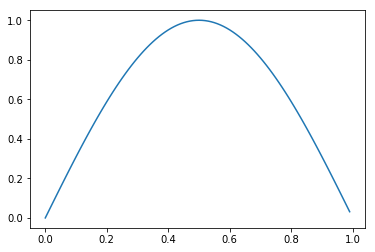

In [41]:
plt.plot(xs,y_true)

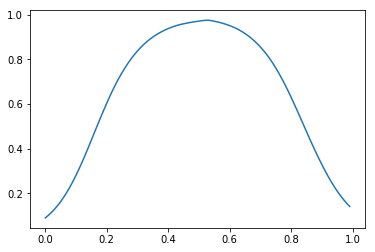

In [40]:
plt.plot(xs,y_pred)

In [55]:
n2 = 100
xs = np.arange(n2)/100.0 * 4
y_true = np.sin(xs * 1*np.pi * f)
y_pred = encoder.predict(xs.reshape(n2,1)).reshape(n2)

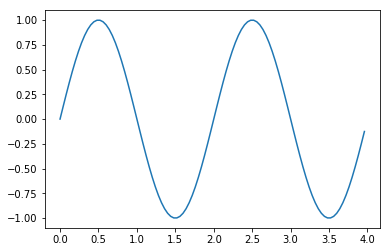

In [56]:
plt.plot(xs,y_true)

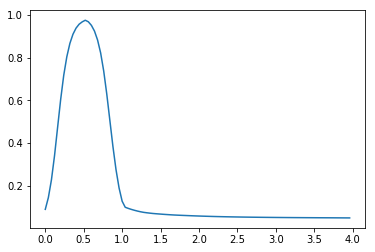

In [57]:
plt.plot(xs,y_pred)